In [1]:
import pandas as pd 
import numpy as np
import dask.dataframe as dd
import ProperDict as PropD
import dask
import os
import requests
from bs4 import BeautifulSoup
import re
import json
import zipfile, io

In [ ]:
%%time
os.chdir(r'F:/LPS/SEC_DB/2020-Q1')

sub = dd.read_csv('sub.tsv', sep='\\t', header=0, sample=2500000, assume_missing=True)
sub[(sub.form == '10-K') & (sub.cik == 12927)].compute()

In [ ]:
sub[(sub['form'] == '10-K') & (sub['cik'] == 12927)]

In [2]:
# allows for long strings
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# disables setting on copy error
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# total number of unique CIKs 
load = dd.read_csv('F:\LPS\SEC_DB\*\sub.tsv', sep='\t', sample=2500000)
cik = load.cik.compute()
len(cik)

In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns

def VisualizeRange(ranged:pd.DataFrame(), rows:list):
    plt.figure(figsize=(10,5))
    names = [ranged['plabel'].iloc[x] for x in rows]
    if len(names) > 7:
        title = 'Various Entries' 
    else:
        title = ' vs '.join(names)

    for r in rows:
        plt.plot([x for x in ranged.columns[3:-4]], ranged[ranged.columns[3:-4]].iloc[r], label=ranged['plabel'].iloc[r])
    plt.title(title)
    plt.legend()
    plt.show()

In [8]:
def RangedFilings(filings: CompanyFilings, statement='BS', form='10-K') -> pd.DataFrame():
    filing_list = []
    subm = filings.sub[filings.sub['form'] == form]
    
    for i in range(subm.shape[0]):
        cadsh = subm['adsh'].iloc[i]
        print('Compiling: ', filings._get_directory(str(int(subm['filed'].iloc[i]))))
        filing_list.append(filings.extract_statement(cadsh, statement=statement)) # most time spent here
        
    filing_list[0].rename(columns={'value' : filing_list[0]['ddate'].iloc[0]}, inplace=True)
    cdf = filing_list[0]
    for f in range(1, len(filing_list)):
        val_date = str(filing_list[f]['ddate'].iloc[0])
        filing_list[f].rename(columns={'value' : val_date}, inplace=True)
        filing_list[f] = filing_list[f][['plabel', val_date]]
        cdf = pd.merge(cdf, filing_list[f], on=['plabel'], how='outer')
    
    cdf.drop_duplicates(subset=['plabel'], inplace=True)
    cdf.drop(['tag','ddate', 'dimh', 'iprx'],axis=1, inplace=True)
    cdf.insert(len(cdf.columns)-1, 'version', cdf.pop('version'))
    cdf.insert(len(cdf.columns)-1, 'qtrs', cdf.pop('qtrs'))
    cdf.insert(len(cdf.columns)-1, 'line', cdf.pop('line'))
    cdf.insert(len(cdf.columns)-1, 'rank', cdf.pop('rank'))
    cdf.insert(1, 'uom', cdf.pop('uom'))
    cdf.reset_index(inplace=True)
    cdf.drop(['index'], axis=1, inplace=True)
    return cdf

In [19]:
%%time
tt = CompanyFilings(ticker='pltr')

Title: PALANTIR TECHNOLOGIES INC. 
Ticker: PLTR 
cik: 1321655
Wall time: 4.11 s


In [21]:
%%time
RF = RangedFilings(tt, form='10-Q')

Compiling:  2021-08
Compiling:  2021-05
Compiling:  2020-11
Wall time: 60 s


In [25]:
RF

,adsh,uom,plabel,20210630.0,20210331.0,20200930.0,version,qtrs,line,rank
0,0000950123-21-010430,USD,Cash and cash equivalents,2.341156e+09,2.339437e+09,1.800190e+09,us-gaap/2021,0.0,7.0,-1.0
1,0000950123-21-010430,USD,Restricted cash,3.675000e+07,3.710600e+07,4.380000e+07,us-gaap/2021,0.0,8.0,-1.0
2,0000950123-21-010430,USD,Accounts receivable,2.429980e+08,1.514000e+08,1.622690e+08,us-gaap/2021,0.0,9.0,-1.0
3,0000950123-21-010430,USD,Prepaid expenses and other current assets,4.164800e+07,6.175500e+07,3.881650e+08,us-gaap/2021,0.0,10.0,-1.0
4,0000950123-21-010430,USD,Total current assets,2.662552e+09,2.589698e+09,2.394424e+09,us-gaap/2021,0.0,11.0,-1.0
5,0000950123-21-010430,USD,"Preferred stock, par value",1.000000e-03,1.000000e-03,1.000000e-03,us-gaap/2021,0.0,11.0,-1.0
6,0000950123-21-010430,shares,"Preferred stock, shares authorized",2.000000e+09,2.000000e+09,2.000000e+09,us-gaap/2021,0.0,12.0,-1.0
7,0000950123-21-010430,USD,"Property and equipment, net",2.482400e+07,2.737800e+07,2.936900e+07,us-gaap/2021,0.0,12.0,-1.0
8,0000950123-21-010430,USD,"Restricted cash, noncurrent",6.191400e+07,7.193300e+07,8.634300e+07,us-gaap/2021,0.0,13.0,-1.0
9,0000950123-21-010430,shares,"Preferred stock, shares issued",0.000000e+00,0.000000e+00,0.000000e+00,us-gaap/2021,0.0,13.0,-1.0


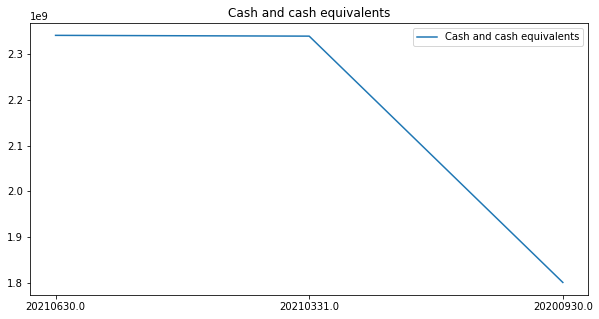

In [26]:
VisualizeRange(RF, [15, 28, ])

In [6]:
# final class for company filings
class CompanyFilings:
    # , num: pd.DataFrame(), pre: pd.DataFrame(), dim: pd.DataFrame(), sub: pd.DataFrame(), tag: pd.DataFrame()
    def __init__(self, ticker=' ', name=' ', cik=' '):
        self.ticker, self.name, self.cik = self._get_company_name(ticker.lower(), name.lower(), cik.lower())
        self._valid_statements = ['BS','CF','IS']
        self._valid_forms = ['10-K', '10-Q']
        self._valid_timeframes = ['yearly', 'quarterly']
        self.collect_filings()
    
    # TODO
    # - add NLP functionality
    # - add 8-K functionality -- not yet supported by xbrl 

    def extract_statement(self, adsh: str, statement='BS') -> pd.DataFrame():
        form_type = self.sub[self.sub['adsh'] == adsh]['form'].iloc[0]
        date_filed = self.sub[self.sub['adsh'] == adsh]['filed'].iloc[0]
        dim  = self.collect_dim(str(date_filed))
        data_tags = self.collect_tag(adsh)
        
        cnum = self.collect_num(adsh)
        cpre = self.collect_pre(adsh, stmt=statement)

        if statement == 'IS':
            # income statement is period-dependant
            qtr = 4 # base is 4 quarters (annual report)
            if form_type == '10-Q':
                qtr = 1
            common_tags = pd.merge(cnum[cnum['qtrs'] == qtr], cpre[['tag','plabel', 'line']], on='tag')
        else:
            common_tags = pd.merge(cnum, cpre[['tag','plabel', 'line']], on='tag')
        
        promoted_dims = self._promote_dimh(cnum, cpre, dim)
        extract_promoted = self._extract_promoted(common_tags, promoted_dims, data_tags)
        return extract_promoted

    def collect_num(self, adsh: str) -> pd.DataFrame():
        numd = PropD.NUM
        numo = {key:value[len(value)-1] for (key,value) in numd.items()}

        date_filed = self.sub[self.sub['adsh'] == adsh]['filed'].iloc[0]
        period = self.sub[self.sub['adsh'] == adsh]['period'].iloc[0]
        fdir = self._get_directory(str(date_filed))
        
        qt = 4
        if self.sub[self.sub['adsh'] == adsh]['form'].iloc[0] == '10-Q':
            qt = 1
        
        num = dd.read_csv(f'F:\LPS\SEC_DB\{fdir}\\num.tsv', sep='\t', dtype=numo, error_bad_lines=False)
        cnum = num[(num.adsh == adsh) & (num.ddate == period) & (num.qtrs.isin([qt, 0]))].compute()
        cnum.drop_duplicates(subset=['tag','dimh','value'],inplace=True)
        return cnum

    def collect_pre(self, adsh: str, stmt='BS') -> pd.DataFrame():
        prep = PropD.PRE
        pred = {key:value[len(value)-1] for (key,value) in prep.items()}

        date_filed = self.sub[self.sub['adsh'] == adsh]['filed'].iloc[0]
        fdir = self._get_directory(str(date_filed))
        pre = dd.read_csv(f'F:\LPS\SEC_DB\{fdir}\\pre.tsv', sep='\t', dtype=pred, error_bad_lines=False, blocksize=None) #no other choice...
        
        cpre = pre[(pre.adsh == adsh) & (pre.stmt == stmt)].compute()
        cpre.sort_values(by='line', inplace=True)
        return cpre

    def collect_tag(self, adsh: str) -> pd.DataFrame():
        tog = PropD.TAG
        togd = {key:value[len(value)-1] for (key,value) in tog.items()}

        date_filed = self.sub[self.sub['adsh'] == adsh]['filed'].iloc[0]
        fdir = self._get_directory(str(date_filed))
        tag = pd.read_csv(f'F:\LPS\SEC_DB\{fdir}\\tag.tsv', sep='\t', dtype=togd, error_bad_lines=False)
        return tag

    def collect_dim(self, date_filed: int) -> pd.DataFrame():
        dime = PropD.DIM
        dimed = {key:value[len(value)-1] for (key,value) in dime.items()}

        fdir = self._get_directory(date_filed)
        dim = dd.read_csv(f'F:\LPS\SEC_DB\{fdir}\\dim.tsv', sep='\t', dtype=dimed, error_bad_lines=False)
        dim = dim.compute()
        return dim
    
    def collect_filings(self) -> pd.DataFrame():
        subd = PropD.SUB
        subdd = {key:value[len(value)-1] for (key,value) in subd.items()}
        
        load = dd.read_csv('F:\LPS\SEC_DB\*\sub.tsv', blocksize=16 * 1024 * 1024, sep='\t', dtype=subdd)
        subm = load[load.cik == self.cik].compute(scheduler='processes', num_workers=4)
        self.sub = subm.sort_values(by='filed', ascending=False)
        return self.sub 
    # -----------------------------------------------

    def _get_company_name(self, ticker:str, name:str, cik:str) -> float:
        os.chdir('F:\LPS')
        if not ticker or not name or not cik: 
            raise ValueError('No names/values given')
        company_entry = {}
        with open('company_tickers.json', 'r') as tick:
            ticker_set = json.load(tick)
            for entry in ticker_set.values():
                if entry['cik_str'] == cik or entry['ticker'].lower() == ticker or entry['title'].lower() == name:
                    company_entry = entry
                    break
            if len(company_entry) == 0: raise ValueError('Company does not exist')
        
        print(f"Title: {company_entry['title'].upper()} \nTicker: {company_entry['ticker'].upper()} \ncik: {company_entry['cik_str']}")
        return company_entry['ticker'], company_entry['title'].lower(), company_entry['cik_str']

    def _get_quarter(self, month:str) -> str:
        if month[0] == '0':
            month = month[1]
        month = int(month)
        if month < 4:
            return 'Q1'
        elif month < 7:
            return 'Q2'
        elif month < 10:
            return 'Q3'
        elif month <= 12:
            return 'Q4'

    def _get_directory(self, date: str) -> str:
        #20091231
        #YYYY MM DD
        if int(date[:6]) >= 202010:
            return date[:4] + '-' + date[4:6] 
        regstr =  date[:4] +'-'+ self._get_quarter(date[4:6])
        return regstr

    # filtering and extracting data from the datasets
    # selects [terms with brackets] from the dataframe, and adds them to a list
    def _dimensionals(self, pre: pd.DataFrame()) -> list: 
        dimensional = pre[pre['plabel'].str.contains(r'\[', na=False)]['plabel']
        labels = []
        for i in range(1, dimensional.shape[0]):
            current = dimensional.iloc[i]
            row_buffer = ''
            for letter in current:
                if letter == ' ':
                    continue
                elif letter == '[':
                    break
                else:
                    row_buffer += letter
            if row_buffer not in labels:
                labels.append(row_buffer)
            else:
                continue
        return labels

    # splits dimension arguments into a parseable list
    def _dim_splitter(self, dimslice: pd.DataFrame()) -> list:
        segs = dimslice.split(';')[:-1]
        key_values = [x.split('=') for x in segs]
        return key_values

    # creates ranking based on how many 'hits' each value's dimhash value had (compared to the _dimensionals found)
    def _promote_dimh(self, num: pd.DataFrame(), pre: pd.DataFrame(), dim: pd.DataFrame()) -> dict:
        hashes = dim[dim['dimhash'].isin(num['dimh'])]
        plabels = self._dimensionals(pre)

        hash_rank = {}
        hash_rank.update({'0x00000000' : -1})
        for i in range(hashes.shape[0]):
            ranking = 0
            if hashes['dimhash'].iloc[i] == '0x00000000':
                continue

            segmented = self._dim_splitter(hashes['segments'].iloc[i])
            for kv in segmented:
                for val in kv:
                    if val in plabels:
                        ranking += 1
            hash_rank.update({hashes['dimhash'].iloc[i] : ranking})
        return hash_rank

    # the actual ranking engine, selects the most relevant values based on their dimhash ranking and iprx value
    def _extract_promoted(self, common_tags: pd.DataFrame(), promoted_dims: dict, data_tags: pd.DataFrame()) -> pd.DataFrame():
        df_list = []
        uniq = list(common_tags['tag'].unique())
        
        i = 0
        for tag in uniq:
            matches = common_tags[common_tags['tag'] == tag]
            matches['rank'] = [promoted_dims[ky] for ky in matches['dimh']]
            
            rmax = matches['rank'].max()
            rmin = matches['rank'].min()
            imin = matches['iprx'].min()

            if rmax > 0:
                up_match = matches[matches['rank'] == rmax]
                if up_match.shape[0] > 1:
                    up_match = up_match[up_match['iprx'] == imin]
            else:
                up_match = matches[matches['rank'] == rmin]
                if up_match.shape[0] > 1:
                    up_match = up_match[up_match['iprx'] == imin]
            df_list.append(up_match)
            i += 1

        # econt = pd.concat(df_list)
        ep = pd.concat(df_list)
        # ep = self._verify_crdr(econt, data_tags)
        ep.insert(1, 'plabel', ep.pop('plabel'))
        ep.insert(2, 'value', ep.pop('value'))
        ep.drop(['footnote', 'dimn', 'coreg', 'durp', 'datp', 'dcml', 'footlen'], axis=1, inplace=True)
        ep.sort_values(by='line', inplace=True)
        ep.dropna(how='all', inplace=True)
        ep.fillna(0)
        return ep

In [5]:
CompanyFilings(ticker='awk')

['.git', '.gitattributes', '.vscode', '20181001.nc.tar', '20181001.nc.tar.gz', '2020q4', '2020q4.zip', '2020q4_v2', '2020q4_v2.zip', '2021_02_notes', '2021_02_notes.zip', 'company.20210104.idx', 'company_tickers.json', 'LPS', 'num.csv', 'num.txt', 'pickles', 'SEC_DB', 'state-19692.log', 'sub.csv', 'sub.txt', 'tag.txt', 'TASKS.txt', 'ticker_set.json', 'ticker_set.txt', 'TP.txt', 'xbrl', 'xbrl.zip', 'XBRL_DEF.txt', 'XML.txt', 'xml_test.xml', '__pycache__']
Title: AMERICAN WATER WORKS COMPANY, INC. 
Ticker: AWK 
cik: 1410636


In [12]:
class FilingsDownloader:
    def __init__(self):
        self.dlinks, self.downloads = self._collect_links()
        self.current = self._current()

    # downloads and extracts entire database from SEC website
    def download_entire_database(self, datapath: str):
        i = 0
        for link in self.downloads:
            fname = link.string.replace(" ", "-")
            os.mkdir(datapath + "\\" + fname)
            
            print(f"Now Downloading: {fname}... ")
            r = requests.get(self.dlinks[i], stream=True)
            
            zipper = zipfile.ZipFile(io.BytesIO(r.content))
            print(f"Extracting {fname}...")
            zipper.extractall(datapath + "\\" + fname)
            
            print(f"Downloaded and Extracted {fname}.\n")
            i += 1
    
    def download_update(self, datapath:str):
        i = 0
        for link in self.downloads:
            comp = link.string.replace(" ", "-")
            if comp not in self.current:
                os.mkdir(datapath + "\\" + comp)

                print(f"Now Downloading: {comp}... ")
                r = requests.get(self.dlinks[i], stream=True)
                
                zipper = zipfile.ZipFile(io.BytesIO(r.content))
                print(f"Extracting {comp}...")
                zipper.extractall(datapath + "\\" + comp)
                
                print(f"Downloaded and Extracted {comp}.\n")
            i += 1

    def download_company_name(self):
        tik = requests.get('https://www.sec.gov/files/company_tickers.json')
        os.chdir('F:\LPS')
        print(f'Downloaded at:{os.getcwd()}')
        with open('ticker_set.json', 'wb') as ticker:
            ticker.write(tik.content)

    def _current(self):
        os.chdir('F:\LPS\SEC_DB')
        return os.listdir(os.getcwd())

    def _collect_links(self):
        # script to collect all download links
        URL = 'https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html'
        r = requests.get(URL)

        soup = BeautifulSoup(r.content, 'html5lib')

        downloads = soup.find_all(href=re.compile('financial-statement-and-notes-data-sets'))
        dlink = ["https://www.sec.gov/" + downloads[i]['href'] for i in range(len(downloads))] 
        return dlink, downloads

In [7]:
fd = FilingsDownloader()
fd.download_update(r'F:\LPS\SEC_DB')

Now Downloading: 2021-06... 
Extracting 2021-06...
Downloaded and Extracted 2021-06.



# ARCHIVED FUNCTIONS
Who knows, maybe they'll be useful again someday...

In [ ]:
# ARCHIVED
def _get_dirlist(self, data: str) -> list:
    os.chdir(r'F:\LPS\SEC_DB\\')
    submissions = []
    for root, dirs, files in os.walk("."):
        for di in dirs:
            if di == data:
                cwd = root +'\\'+ di
                Submissions.append(cwd)
    return submissions

In [ ]:
# ARCHIVED
# helper function
# turns all tags found in dim.tsv into a pandas dataset, w/ correlated dimhash 
def searchable_dimensions(dim: pd.DataFrame()) -> pd.DataFrame():
    all_tags = []
    c=0 
    for i in range(dim.shape[0]):
        if type(dim['segments'].iloc[i]) == float:
            continue
        
        current = dim['segments'].iloc[i]
        start = 0
        stop = 0 
        for letter in current:
            if letter == ';' or letter == '=':
                all_tags.append([current[start:stop], dim['dimhash'].iloc[i]])
                start = stop+1
                c += 1
            stop+=1

        if i % 1000 == 0:
            print(i, end=' ')

    all_possible_tags = pd.DataFrame(all_tags, columns=['tag', 'dimhash'])
    all_possible_tags.dropna(how='any', inplace=True)
    all_possible_tags.drop_duplicates(inplace=True)
    return all_possible_tags

In [ ]:
# ARCHIVED dimensionals
dimensional = pre[pre['plabel'].str.contains(r'\[', na=False)]['plabel']
    labels = []
    for i in range(1, dimensional.shape[0]):
        current = dimensional.iloc[i]
        row_buffer = ''
        start = 0
        c = 0 
        for letter in current:
            if letter == ']' or letter == '}':
                break
            elif letter == '[' or letter == ':':
                start = c+1
            c += 1
        labels.append(current[start:c])

In [ ]:
# ARCHIVED
# all tags with common ranking
for tag in uniq:
    matches = common_tags[common_tags['tag'] == tag]
    matches['rank'] = [promoted_dims[ky] for ky in matches['dimh']]
    lmax = matches['rank'].max()
    lmin = matches['rank'].min()
    if matches.shape[0] > 1:
        if lmax == lmin:
            display(matches)

In [ ]:
%%time
# ARCHIVED
# opens relevant .tsv filings
os.chdir(r'F:/LPS/2021_02_notes')

sub = pd.read_csv('sub.tsv', sep='\t', header=0)
num = pd.read_csv('num.tsv', sep='\t', header=0)
pre = pd.read_csv('pre.tsv', sep='\t', header=0)
dim = pd.read_csv('dim.tsv', sep='\t', header=0)
txt = pd.read_csv('txt.tsv', sep='\t', header=0)
data_tags = pd.read_csv('tag.tsv', sep='\t', header=0)

In [ ]:
# ARCHIVED
# income statement is over set period of time, check qtrs 
isnum = collect_num('0000012927-21-000011', 20201231, num)
ispre = collect_pre('0000012927-21-000011', 20201231, pre, stmt='IS')

promoted_dims = promote_dimh(isnum, ispre, dim)
ct = pd.merge(isnum[isnum['qtrs'] == 4], ispre[['tag','plabel', 'line']], on='tag')
i_s = extract_promoted(ct, promoted_dims, data_tags) 
i_s